In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import mr_forecast as mr
from astropy.io import ascii
from scipy.optimize import root_scalar

%matplotlib inline

## Definitions of fields can be found at:
### confirmed planets:
https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html
### KOIs:
https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [2]:
KOIs = ascii.read("../../../KOIs_chen2018_goodSystems.csv")
print(KOIs)
print(len(KOIs.colnames))
print(KOIs.colnames)

 kepid   kepoi_name  kepler_name  ...   koi_pmass_err1     koi_pmass_err2  
-------- ---------- ------------- ... ------------------ ------------------
 1026957  K00958.01            -- ...  5.769464972554899  3.244408578305821
 1161345  K00984.01            -- ...  6.326092545818279 3.5574232654922424
 1429589  K04923.01            -- ... 1.5735103860765358 0.7378008287493754
 1431122  K00994.01            -- ...  2.419108737036141 1.0891220900035181
 1432789  K00992.01  Kepler-745 b ...  5.964185807741979  3.027858259246558
 1432789  K00992.02            -- ...  2.437079035986733 1.0697247065679856
 1717722  K03145.01            -- ... 2.6787928971009194 1.3399128949332408
 1717722  K03145.02            -- ... 1.3217080679402717 0.6511151044108447
 1718189  K00993.03            -- ... 3.0588005877402042 1.4588377614817154
 1718189  K00993.02  Kepler-262 b ... 2.9891737858212397  1.378072373671277
     ...        ...           ... ...                ...                ...
12645057  K0

# Constraints on hypothetical in-between planets

1432789


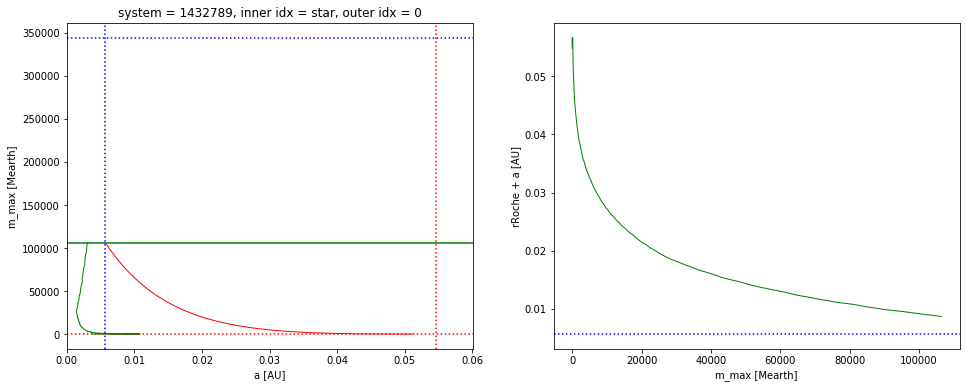

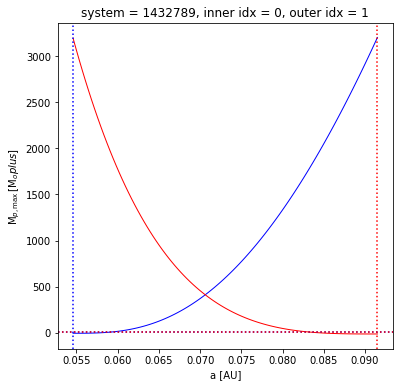

'\nnp.savetxt(savename,constraints,delimiter=" ",\n           fmt="%d %d %d %f %f %f %f %f %f %f %f %f %f %f",\n           header="kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr")\n'

In [6]:
# For all the systems with 2+ planets, bracket Rp, P of a planet between each two observed.

# Relevant columns:
# KOIs('kepid')

# Directly observed:
# KOIs('koi_steff') [K]
# KOIs('koi_slogg') [log10cm/s]
# KOIs('koi_ror')
# KOIs('koi_period') [days] # Will bracket P_target

# Isochrone model-dependent:
# KOIs('koi_srad') [Rsun]
# KOIs('koi_smass') [Msun]
# KOIs('koi_prad') [Rearth]
# KOIs('koi_insol') [Searth]
# KOIs('koi_sma') [AU] # Will bracket a_target

# Forecaster-modeled:
# KOIs('koi_pmass') [Mearth]

# Will be calculated:
# Mutual Hill radii: will bracket Mp_target

# Will be reverse-Forecaster modeled:
# Brackets Rp_target

# want an array that looks like:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr

constraints = np.zeros((1,14))

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.sort(np.unique(np.array(KOIs['kepid'])))
#print(len(unique_kepid))

np.random.seed(42)
unique_kepid_shuffle = np.random.permutation(unique_kepid)

unique_kepid_70 = np.sort(unique_kepid_shuffle[:int(0.7*len(unique_kepid_shuffle))])
unique_kepid_30 = np.sort(unique_kepid_shuffle[int(0.7*len(unique_kepid_shuffle)):])

#print(len(unique_kepid_70))
#print(len(unique_kepid_30))

kepids_toloop = unique_kepid
#features = mod_features
#means = np.mean(features,axis=0)
#sigmas = np.std(features,axis=0)
savename = "./realPlanets_obs/realKOIs_hypotheticalConstraints.txt"


for ID in kepids_toloop[4:5]:
    print(ID)
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #constrain planet between star and 1st observed planet
    # The constraint here: we want the largest allowable planet for which the star's Roche limit 
    # exceeds Rstar + Rp.
    Ps = KOIs['koi_period'][thisSystem_idxs]
    #sort KOIs from inner to outer
    sort = np.argsort(Ps)
    thisSystem_idxs = thisSystem_idxs[sort]
    Ps = KOIs['koi_period'][thisSystem_idxs]
    count = KOIs['koi_count'][thisSystem_idxs[0]]
    Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Msun to Earth masses
    Rstar = KOIs['koi_srad'][thisSystem_idxs[0]] * 109.2 # Rsun to Earth radii
    P_innermost = KOIs['koi_period'][thisSystem_idxs[0]]    

    
    constrainedPlanet = np.zeros((14))
    constrainedPlanet[0] = ID
    constrainedPlanet[1] = 0
    constrainedPlanet[2] = 1
    constrainedPlanet[3] = KOIs['koi_srad'][thisSystem_idxs[0]]/215.032
    constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[0]]
    # in units of Rearth**3 Mearth**-1 d**-2
    G_ = 6.674e-11 * (6371e3)**-3 * 5.972e24 * 86400**2
    constrainedPlanet[5] = np.sqrt( (4*np.pi**2 * Rstar**3) / (G_*Mstar) )
    constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[0]]
            
    a_inner = KOIs['koi_srad'][thisSystem_idxs[0]]/215.032 #convert solrad to AU
    a_outer = KOIs['koi_sma'][thisSystem_idxs[0]]
            
    m_inner = Mstar
    m_outer = (KOIs['koi_pmass'][thisSystem_idxs[0]])+(KOIs['koi_pmass_err1'][thisSystem_idxs[0]])
            
    a_allow = np.linspace(a_inner, a_outer, 100)
    #mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
    mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer

    # eliminate negative masses
    a_allow = a_allow[mmax_fromouter > 0]
    mmax_fromouter = mmax_fromouter[mmax_fromouter > 0]
    
    rmax_fromouter = np.zeros_like(mmax_fromouter)
    rRoche = np.zeros_like(mmax_fromouter)
    for i in range(len(mmax_fromouter)):
        try:
            rmax_fromouter[i], Rplus, Rminus = mr.Mstat2R(mean=mmax_fromouter[i], std=0.01, unit='Earth', sample_size=100)
            
        except TypeError:
            #print("mmax is {0}".format(mmax_fromouter[i]))
            rmax_fromouter[i] = 1000
            Rplus = 0
            Rminus= 0
            #print(mmax_fromouter[i])
        rRoche[i] = rmax_fromouter[i] * ( 2 * (Mstar/mmax_fromouter[i]))**(1./3.)
    
    try:
        mmax = np.max(mmax_fromouter[rRoche > a_inner])
        Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
    except ValueError:
        mmmax = 0
        Rmedian = 0
        Rplus = 0
        Rminus = 0
    except TypeError:
        print("mmax is {0}".format(mmax))
        Rmedian = 1000
        Rplus = 0
        Rminus= 0
    
    #print(rRoche)
    fig,axes = plt.subplots(1,2,figsize=(16,6))
    #axes[0].plot(a_allow,mmax_frominner,'b-',lw=1)
    axes[0].plot(a_allow,mmax_fromouter,'r-',lw=1)
    axes[0].plot((rRoche*((6371e3)/(1.496e11))),mmax_fromouter,'g-',lw=1)
    axes[0].axvline(a_inner,color='b',ls=':')
    axes[0].axvline(a_outer,color='r',ls=':')

    axes[0].axhline(m_inner,color='b',ls=':')
    axes[0].axhline(m_outer,color='r',ls=':')
    axes[0].axhline(mmax,color='g',ls='-')

    axes[0].set_xlabel("a [AU]")
    axes[0].set_ylabel("m_max [Mearth]")
    axes[0].set_title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,"star","0"))
    axes[0].set_xlim(0,a_outer*1.1)
    
    axes[1].plot(mmax_fromouter,(rRoche*((6371e3)/(1.496e11)))+a_allow,'g-',lw=1)
    axes[1].axhline(a_inner,color='b',ls=':')
    axes[1].set_xlabel('m_max [Mearth]')
    axes[1].set_ylabel('rRoche + a [AU]')
    
    plt.show()
    
    #print(mmax_fromouter)
    #print(mmax)
    #print(Rmedian)
    constrainedPlanet[7] = mmax
    constrainedPlanet[8] = Rmedian
    constrainedPlanet[9] = Rplus
    constrainedPlanet[10] = Rminus
    
    constrainedPlanet[11] = Rmedian/Rstar
    constrainedPlanet[12] = Rplus/Rstar
    constrainedPlanet[13] = Rminus/Rstar
    
    constraints = np.vstack((constraints,constrainedPlanet))
    
    #Multi-planet systems only
    if len(thisSystem_idxs) > 1:
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]
        
        Ps = KOIs['koi_period'][thisSystem_idxs]
        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Earth masses
        
        for j in range(0,count-1):
            constrainedPlanet = np.zeros((14))
            constrainedPlanet[0] = ID
            constrainedPlanet[1] = j+1
            constrainedPlanet[2] = j+2
            constrainedPlanet[3] = KOIs['koi_sma'][thisSystem_idxs[j]]
            constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[j+1]]
            constrainedPlanet[5] = KOIs['koi_period'][thisSystem_idxs[j]]
            constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[j+1]]
            
            a_inner = KOIs['koi_sma'][thisSystem_idxs[j]]
            a_outer = KOIs['koi_sma'][thisSystem_idxs[j+1]]
            
            m_inner = KOIs['koi_pmass'][thisSystem_idxs[j]] + KOIs['koi_pmass_err1'][thisSystem_idxs[j]]
            m_outer = KOIs['koi_pmass'][thisSystem_idxs[j+1]] + KOIs['koi_pmass_err1'][thisSystem_idxs[j+1]]
            
            a_allow = np.linspace(a_inner, a_outer, 100)
            mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
            mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer
            
            # define function to find the root of
            def mmax_overall(a,a_inner,a_outer,m_inner,m_outer,Mstar):
                mmax_frominner = (Mstar/np.sqrt(3)) * ((a-a_inner)/(a+a_inner))**3 - m_inner
                mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a)/(a_outer+a))**3 - m_outer
            
                return mmax_frominner - mmax_fromouter
            
            try:
                a_mmax_obj = root_scalar(mmax_overall,args=(a_inner,a_outer,m_inner,m_outer,Mstar),bracket=(a_inner,a_outer))
                a_mmax = a_mmax_obj.root
                mmax = (Mstar/np.sqrt(3)) * ((a_mmax-a_inner)/(a_mmax+a_inner))**3 - m_inner
                
            except ValueError: #these are all gonna be negative anyway, doesn't really matter
                whichConstrains = np.argmin((mmax_frominner[0],mmax_fromouter[0]))
                if whichConstrains == 0:
                    mmax = np.max(mmax_frominner)
                else:
                    mmax = np.max(mmax_fromouter)
            
            #catch negative masses
            if mmax < 0:
                mmmax = 0
                Rmedian = 0
                Rplus = 0
                Rminus = 0
                
            else:
                try:
                    Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
                except TypeError:
                    print("mmax is {0}".format(mmax))
                    Rmedian = 1000
                    Rplus = 0
                    Rminus= 0
            
            constrainedPlanet[7] = mmax
            constrainedPlanet[8] = Rmedian
            constrainedPlanet[9] = Rplus
            constrainedPlanet[10] = Rminus
            
            constrainedPlanet[11] = Rmedian/Rstar
            constrainedPlanet[12] = Rplus/Rstar
            constrainedPlanet[13] = Rminus/Rstar
            
            
            #print(mmax/317.8)#jupiter masses---i.e. is this a meaningful constraint?
            
            fig = plt.figure(figsize=(6,6))
            plt.plot(a_allow,mmax_frominner,'b-',lw=1)
            plt.plot(a_allow,mmax_fromouter,'r-',lw=1)
            plt.axvline(a_inner,color='b',ls=':')
            plt.axvline(a_outer,color='r',ls=':')
            #plt.axvline(a_mmax,color='g',ls=':')
            
            plt.axhline(m_inner,color='b',ls=':')
            plt.axhline(m_outer,color='r',ls=':')
            #plt.axhline(mmax,color='g',ls=':')
            plt.xlabel(r"a [AU]")
            plt.ylabel(r"$\mathrm{M}_{p,\mathrm{max}}\, [\mathrm{M}_\oplus]$")
            plt.title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,j,j+1))
            plt.show()
            
            constraints = np.vstack((constraints,constrainedPlanet))
constraints = constraints[1:]   
'''
np.savetxt(savename,constraints,delimiter=" ",
           fmt="%d %d %d %f %f %f %f %f %f %f %f %f %f %f",
           header="kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr")
'''

In [ ]:
print(np.shape(constraints))

fig,axes = plt.subplots(1,2,figsize=(16,6))
axes[0].hist(constraints[:,7]/317.8,range=(0,20),color='b',alpha=0.7)
axes[0].set_xlabel("Maximum mass in Mjup")
axes[1].hist(constraints[:,8]/11.209,range=(0,100),color='r',alpha=0.7)
axes[1].hist((constraints[:,8]+constraints[:,9])/11.209,range=(0,100),color='y',alpha=0.7)

axes[1].set_xlabel("Maximum radius in Rjup")
plt.show()

# Constrain the real target planets as if they weren't observed

3128552


'\nnp.savetxt(savename,constraints,delimiter=" ",\n           fmt="%d %d %d %f %f %f %f %f %f %f %f %f %f %f",\n           header="kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr")\n'

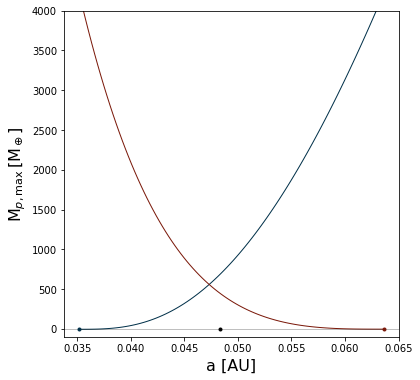

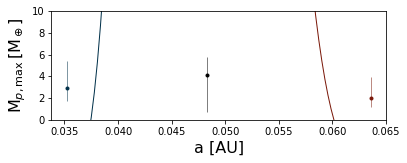

In [37]:
# For all the systems with 2+ planets, bracket Rp, P of a planet between each two observed.

# Relevant columns:
# KOIs('kepid')

# Directly observed:
# KOIs('koi_steff') [K]
# KOIs('koi_slogg') [log10cm/s]
# KOIs('koi_ror')
# KOIs('koi_period') [days] # Will bracket P_target

# Isochrone model-dependent:
# KOIs('koi_srad') [Rsun]
# KOIs('koi_smass') [Msun]
# KOIs('koi_prad') [Rearth]
# KOIs('koi_insol') [Searth]
# KOIs('koi_sma') [AU] # Will bracket a_target

# Forecaster-modeled:
# KOIs('koi_pmass') [Mearth]

# Will be calculated:
# Mutual Hill radii: will bracket Mp_target

# Will be reverse-Forecaster modeled:
# Brackets Rp_target

# want an array that looks like:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr

constraints = np.zeros((1,14))

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.sort(np.unique(np.array(KOIs['kepid'])))
#print(len(unique_kepid))

np.random.seed(42)
unique_kepid_shuffle = np.random.permutation(unique_kepid)

unique_kepid_70 = np.sort(unique_kepid_shuffle[:int(0.7*len(unique_kepid_shuffle))])
unique_kepid_30 = np.sort(unique_kepid_shuffle[int(0.7*len(unique_kepid_shuffle)):])

#print(len(unique_kepid_70))
#print(len(unique_kepid_30))

kepids_toloop = unique_kepid
#features = mod_features
#means = np.mean(features,axis=0)
#sigmas = np.std(features,axis=0)
savename = "./realPlanets_obs/realKOIs_targetConstraints.txt"


#for ID in kepids_toloop[103:104]: for Kepler-1073c plot only!!
for ID in kepids_toloop:
    print(ID)
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #constrain planet between star and 1st observed planet
    # The constraint here: we want the largest allowable planet for which the star's Roche limit 
    # exceeds Rstar + Rp.
    Ps = KOIs['koi_period'][thisSystem_idxs]
    #sort KOIs from inner to outer
    sort = np.argsort(Ps)
    
    thisSystem_idxs = thisSystem_idxs[sort]
    Ps = KOIs['koi_period'][thisSystem_idxs]
    count = KOIs['koi_count'][thisSystem_idxs[0]]
    Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Msun to Earth masses
    Rstar = KOIs['koi_srad'][thisSystem_idxs[0]] * 109.2 # Rsun to Earth radii
    P_innermost = KOIs['koi_period'][thisSystem_idxs[0]]
    
    #Multi-planet systems only
    if len(thisSystem_idxs) > 1:
    
        constrainedPlanet = np.zeros((14))
        constrainedPlanet[0] = ID
        constrainedPlanet[1] = 0
        constrainedPlanet[2] = 2
        constrainedPlanet[3] = KOIs['koi_srad'][thisSystem_idxs[1]]/215.032 #AU
        constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[1]] #AU
        # in units of Rearth**3 Mearth**-1 d**-2
        G_ = 6.674e-11 * (6371e3)**-3 * 5.972e24 * 86400**2
        constrainedPlanet[5] = np.sqrt( (4*np.pi**2 * Rstar**3) / (G_*Mstar) )
        constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[1]]

        a_inner = KOIs['koi_srad'][thisSystem_idxs[1]]/215.032 #convert solrad to AU
        a_outer = KOIs['koi_sma'][thisSystem_idxs[1]]

        m_inner = Mstar
        m_outer = KOIs['koi_pmass'][thisSystem_idxs[1]] + KOIs['koi_pmass_err1'][thisSystem_idxs[1]]

        a_allow = np.linspace(a_inner, a_outer, 100)
        #mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
        mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer

        # eliminate negative masses
        a_allow = a_allow[mmax_fromouter > 0]
        mmax_fromouter = mmax_fromouter[mmax_fromouter > 0]

        rmax_fromouter = np.zeros_like(mmax_fromouter)
        rRoche = np.zeros_like(mmax_fromouter)
        for i in range(len(mmax_fromouter)):
            try:
                rmax_fromouter[i], Rplus, Rminus = mr.Mstat2R(mean=mmax_fromouter[i], std=0.01, unit='Earth', sample_size=100)

            except TypeError:
                print("mmax is {0}".format(mmax_fromouter[i]))
                rmax_fromouter[i] = 1000
                Rplus = 0
                Rminus= 0
                print(mmax_fromouter[i])
            rRoche[i] = rmax_fromouter[i] * ( 2 * (Mstar/mmax_fromouter[i]))**(1./3.)

        try:
            mmax = np.max(mmax_fromouter[rRoche > a_inner])
            Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
        except ValueError:
            mmmax = 0
            Rmedian = 0
            Rplus = 0
            Rminus = 0
        except TypeError:
            print("mmax is {0}".format(mmax))
            Rmedian = 1000
            Rplus = 0
            Rminus= 0
        """
        #print(rRoche)
        fig,axes = plt.subplots(1,2,figsize=(16,6))
        #axes[0].plot(a_allow,mmax_frominner,'b-',lw=1)
        axes[0].plot(a_allow,mmax_fromouter,'r-',lw=1)
        axes[0].plot((rRoche*((6371e3)/(1.496e11))),mmax_fromouter,'g-',lw=1)
        axes[0].axvline(a_inner,color='b',ls=':')
        axes[0].axvline(a_outer,color='r',ls=':')

        axes[0].axhline(m_inner,color='b',ls=':')
        axes[0].axhline(m_outer,color='r',ls=':')
        axes[0].axhline(mmax,color='g',ls='-')

        axes[0].set_xlabel("a [AU]")
        axes[0].set_ylabel("m_max [Mearth]")
        axes[0].set_title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,"star","0"))
        axes[0].set_xlim(0,a_outer*1.1)

        axes[1].plot(mmax_fromouter,(rRoche*((6371e3)/(1.496e11)))+a_allow,'g-',lw=1)
        axes[1].axhline(a_inner,color='b',ls=':')
        axes[1].set_xlabel('m_max [Mearth]')
        axes[1].set_ylabel('rRoche + a [AU]')

        plt.show()
        """

        constrainedPlanet[7] = mmax
        constrainedPlanet[8] = Rmedian
        constrainedPlanet[9] = Rplus
        constrainedPlanet[10] = Rminus
        
        constrainedPlanet[11] = Rmedian/Rstar
        constrainedPlanet[12] = Rplus/Rstar
        constrainedPlanet[13] = Rminus/Rstar

        constraints = np.vstack((constraints,constrainedPlanet))
    
    #Multi-planet systems only
    if len(thisSystem_idxs) > 2:
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Earth masses
        
        for j in range(0,count-2):
        #for j in range(1): # for Kepler-1073c plot only!!
            constrainedPlanet = np.zeros((14))
            constrainedPlanet[0] = ID
            constrainedPlanet[1] = j+1
            constrainedPlanet[2] = j+3
            constrainedPlanet[3] = KOIs['koi_sma'][thisSystem_idxs[j]]
            constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[j+2]]
            constrainedPlanet[5] = KOIs['koi_period'][thisSystem_idxs[j]]
            constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[j+2]]
            
            a_inner = KOIs['koi_sma'][thisSystem_idxs[j]]
            a_outer = KOIs['koi_sma'][thisSystem_idxs[j+2]]
            
            m_inner = KOIs['koi_pmass'][thisSystem_idxs[j]] + KOIs['koi_pmass_err1'][thisSystem_idxs[j]]
            m_outer = KOIs['koi_pmass'][thisSystem_idxs[j+2]] + KOIs['koi_pmass_err1'][thisSystem_idxs[j+2]]
            
            a_allow = np.linspace(a_inner, a_outer, 100)
            mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
            mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer
            
            # define function to find the root of
            def mmax_overall(a,a_inner,a_outer,m_inner,m_outer,Mstar):
                mmax_frominner = (Mstar/np.sqrt(3)) * ((a-a_inner)/(a+a_inner))**3 - m_inner
                mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a)/(a_outer+a))**3 - m_outer
            
                return mmax_frominner - mmax_fromouter
            
            try:
                a_mmax_obj = root_scalar(mmax_overall,args=(a_inner,a_outer,m_inner,m_outer,Mstar),bracket=(a_inner,a_outer))
                a_mmax = a_mmax_obj.root
                mmax = (Mstar/np.sqrt(3)) * ((a_mmax-a_inner)/(a_mmax+a_inner))**3 - m_inner
                
            except ValueError: #these are all gonna be negative anyway, doesn't really matter
                whichConstrains = np.argmin((mmax_frominner[0],mmax_fromouter[0]))
                if whichConstrains == 0:
                    mmax = np.max(mmax_frominner)
                else:
                    mmax = np.max(mmax_fromouter)
            
            #catch negative masses
            if mmax < 0:
                mmmax = 0
                Rmedian = 0
                Rplus = 0
                Rminus = 0
                
            else:
                try:
                    Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
                except TypeError:
                    print("mmax is {0}".format(mmax))
                    Rmedian = 1000
                    Rplus = 0
                    Rminus= 0
            
            constrainedPlanet[7] = mmax
            constrainedPlanet[8] = Rmedian
            constrainedPlanet[9] = Rplus
            constrainedPlanet[10] = Rminus
            
            constrainedPlanet[11] = Rmedian/Rstar
            constrainedPlanet[12] = Rplus/Rstar
            constrainedPlanet[13] = Rminus/Rstar
                
            '''
            #print(mmax/317.8)#jupiter masses---i.e. is this a meaningful constraint?
            
            fig = plt.figure(figsize=(6,6))
            plt.errorbar(x=.0483,y=4.10,yerr=np.atleast_2d(np.array((3.38,1.71))).T,color='k',marker='.',capsize=0,elinewidth=0.5)
            plt.errorbar(x=.0352,y=2.88,yerr=np.atleast_2d(np.array((1.15,2.49))).T,color='#003049',marker='.',capsize=0,elinewidth=0.5)
            plt.errorbar(x=.0636,y=2.0,yerr=np.atleast_2d(np.array((0.85,1.9))).T,color='#7a1809',marker='.',capsize=0,elinewidth=0.5)
            
            plt.plot(a_allow,mmax_frominner,ls='-',color='#003049',lw=1)
            plt.plot(a_allow,mmax_fromouter,ls='-',color='#7a1809',lw=1)
            #plt.axvline(a_inner,color='#003049',ls=':')
            #plt.axvline(a_outer,color='#7a1809',ls=':')
            #plt.axvline(a_mmax,color='g',ls=':')
            
            #plt.axhline(m_inner,color='b',ls=':')
            #plt.axhline(m_outer,color='r',ls=':')
            #plt.axhline(mmax,color='g',ls=':')
            plt.axhline(0,color='k',ls='-',alpha=0.5,lw=0.5)
            plt.xlabel(r"a [AU]",fontsize=16)
            plt.ylabel(r"$\mathrm{M}_{p,\mathrm{max}}\, [\mathrm{M}_\oplus]$",fontsize=16)
            #plt.title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,j,j+2))
            plt.ylim(-100,4000)
            #plt.show()
            plt.savefig("./kepler-1073c_constraints.pdf",fmt="pdf",bbox_inches="tight")
            
            fig = plt.figure(figsize=(6,2))
            plt.errorbar(x=.0483,y=4.10,yerr=np.atleast_2d(np.array((3.38,1.71))).T,color='k',marker='.',capsize=0,elinewidth=0.5)
            plt.errorbar(x=.0352,y=2.88,yerr=np.atleast_2d(np.array((1.15,2.49))).T,color='#003049',marker='.',capsize=0,elinewidth=0.5)
            plt.errorbar(x=.0636,y=2.0,yerr=np.atleast_2d(np.array((0.85,1.9))).T,color='#7a1809',marker='.',capsize=0,elinewidth=0.5)
            
            plt.plot(a_allow,mmax_frominner,ls='-',color='#003049',lw=1)
            plt.plot(a_allow,mmax_fromouter,ls='-',color='#7a1809',lw=1)
            #plt.axvline(a_inner,color='#003049',ls=':')
            #plt.axvline(a_outer,color='#7a1809',ls=':')
            #plt.axvline(a_mmax,color='g',ls=':')
            
            #plt.axhline(m_inner,color='b',ls=':')
            #plt.axhline(m_outer,color='r',ls=':')
            #plt.axhline(mmax,color='g',ls=':')
            plt.axhline(0,color='k',ls='-',alpha=0.5,lw=0.5)
            plt.xlabel(r"a [AU]",fontsize=16)
            plt.ylabel(r"$\mathrm{M}_{p,\mathrm{max}}\, [\mathrm{M}_\oplus]$",fontsize=16)
            #plt.title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,j,j+2))
            plt.ylim(0,10)
            #plt.show()
            plt.savefig("./kepler-1073c_constraints_zoom.pdf",fmt="pdf",bbox_inches="tight")
            '''
            
            constraints = np.vstack((constraints,constrainedPlanet))
constraints = constraints[1:]
"""
np.savetxt(savename,constraints,delimiter=" ",
           fmt="%d %d %d %f %f %f %f %f %f %f %f %f %f %f",
           header="kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr")
"""

In [22]:
r_mean = 1.79 
r_sigma = 0.3
Mmedian, Mplus, Mminus = mr.Rstat2M(r_mean, r_sigma, unit='Earth', sample_size=10000, grid_size=1000)
print(Mmedian)
print(Mplus)
print(Mminus)

4.098978833346053
3.3811298474450693
1.7085959657178504


(856, 14)


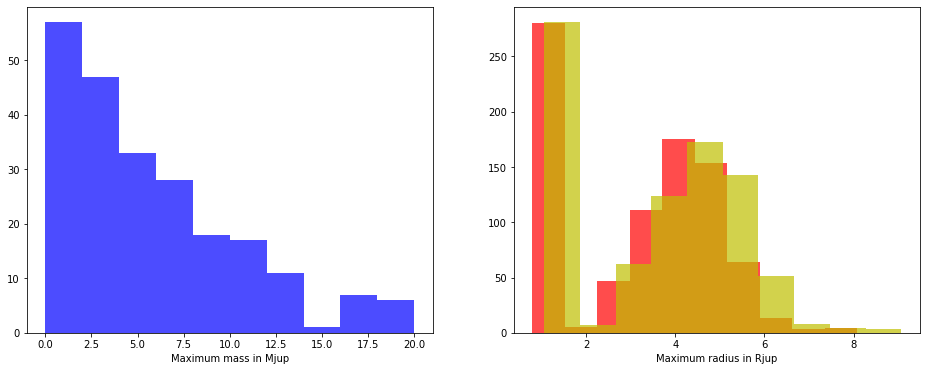

In [58]:
print(np.shape(constraints))

fig,axes = plt.subplots(1,2,figsize=(16,6))
axes[0].hist(constraints[:,7]/317.8,range=(0,20),color='b',alpha=0.7)
axes[0].set_xlabel("Maximum mass in Mjup")
axes[1].hist(constraints[:,8]/11.209,color='r',alpha=0.7)
axes[1].hist((constraints[:,8]+constraints[:,9])/11.209,color='y',alpha=0.7)

axes[1].set_xlabel("Maximum radius in Rjup")
plt.show()

In [139]:
idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.sort(np.unique(np.array(KOIs['kepid'])))
print(len(unique_kepid))

np.random.seed(42)
unique_kepid_shuffle = np.random.permutation(unique_kepid)

unique_kepid_70 = np.sort(unique_kepid_shuffle[:int(0.7*len(unique_kepid_shuffle))])
unique_kepid_30 = np.sort(unique_kepid_shuffle[int(0.7*len(unique_kepid_shuffle)):])

print(len(unique_kepid_70))
print(len(unique_kepid_30))

print(unique_kepid_30)

2656
1859
797
[ 1161345  1432789  1718958  1724719  1849702  1873513  2019199  2142522
  2304320  2439243  2441495  2442448  2443393  2449431  2557816  2571238
  2579043  2581554  2693736  2715135  2718778  2853029  2853446  2854914
  2860866  2986833  2987027  2990873  2997459  3001955  3097926  3103227
  3103473  3109930  3114167  3114811  3116412  3118797  3122913  3128552
  3219643  3234843  3244792  3248501  3323887  3328080  3340165  3346154
  3353050  3356156  3425851  3426367  3440118  3450040  3531558  3545135
  3545840  3554031  3557560  3629330  3642289  3657758  3728432  3732821
  3745559  3745690  3752110  3758922  3831053  3833007  3835670  3847138
  3859628  3867794  3955817  3962357  3969687  4035640  4043190  4049901
  4060229  4072955  4077526  4078311  4138008  4139254  4147444  4150804
  4157325  4164511  4248120  4254466  4274548  4346178  4346339  4472818
  4545570  4566848  4571844  4587135  4656049  4676964  4742420  4750669
  4757437  4770365  4773392  4820550 

856
[ 1432789.  1717722.  1718189.  1718189.  1724719.  1871056.  1996180.
  2019477.  2165002.  2302548.  2305866.  2307415.  2438264.  2715695.
  2854698.  2854914.  2975770.  2989404.  3128552.  3128552.  3128552.
  3217264.  3217264.  3218908.  3218908.  3234598.  3234843.  3245969.
  3323887.  3323887.  3326377.  3338885.  3342794.  3342970.  3529290.
  3541946.  3541946.  3548044.  3548044.  3554031.  3554031.  3559860.
  3559935.  3632089.  3634051.  3640905.  3642289.  3645438.  3645438.
  3656121.  3657758.  3661886.  3734418.  3745690.  3745690.  3747817.
  3867615.  3937519.  3939150.  3942670.  3962243.  3962243.  3967760.
  4077526.  4077526.  4077526.  4139816.  4139816.  4139816.  4142847.
  4157325.  4157325.  4157325.  4173026.  4249725.  4263293.  4263293.
  4270253.  4275721.  4349452.  4385148.  4455231.  4455231.  4458082.
  4466677.  4466677.  4472818.  4478168.  4545187.  4563268.  4633570.
  4636578.  4636578.  4644952.  4644952.  4645174.  4665571.  4725681.
  

P upper limit too low
3245969.0
0.0
2.0
ror upper limit too low
3634051.0
0.0
2.0
ror upper limit too low
5792202.0
3.0
5.0


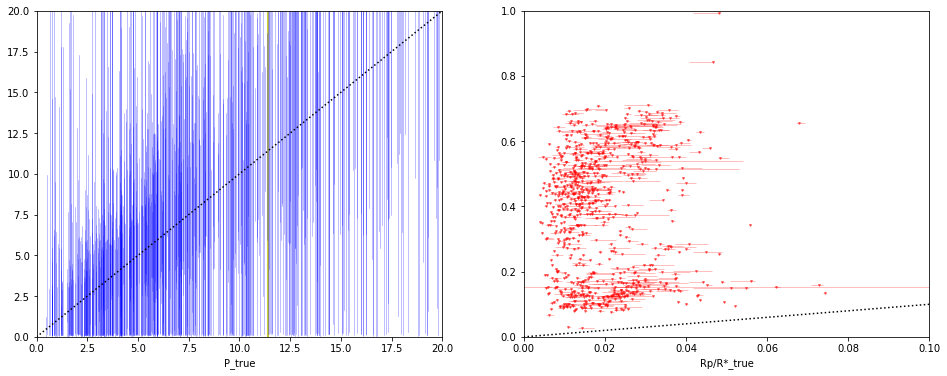

In [142]:
# Plot constraints vs. true

# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr
constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")
#print(len(constraints))
#print(constraints[:,0])
ids_int = constraints[:,0].astype(int)
CVmask = [id_ in unique_kepid_30 for id_ in ids_int]
#print(CVmask)
#print(len(constraints[CVmask]))


fig, axes = plt.subplots(1,2,figsize=(16,6))
for i in range(len(constraints)):
    ID = constraints[i,0]
    thisSys = KOIs[KOIs['kepid'] == ID]
    thisSys_P = np.array(thisSys['koi_period'])
    thisSys_Rp = np.array(thisSys['koi_prad'])[np.argsort(thisSys_P)]
    thisSys_ror = np.array(thisSys['koi_ror'])[np.argsort(thisSys_P)]
    thisSys_ror_err_u = np.abs(np.array(thisSys['koi_ror_err1'])[np.argsort(thisSys_P)])
    thisSys_ror_err_l = np.abs(np.array(thisSys['koi_ror_err2'])[np.argsort(thisSys_P)])
    thisSys_P = thisSys_P[np.argsort(thisSys_P)]
    
    innerplanetIdx = int(constraints[i,1])
    
    #axes[0].axvline(x=thisSys_P[innerplanetIdx],ymin=constraints[i,5],ymax=constraints[i,6],color='b',lw=0.5,alpha=0.5)
    
    axes[0].plot(thisSys_P[innerplanetIdx]*np.ones((2)),constraints[i,5:7],color='b',marker='None',lw=0.5,alpha=0.5)
    #axes[0].plot(thisSys_P[innerplanetIdx],constraints[i,6],color='r',marker='o',ms=5)
    
    if constraints[i,6] < (thisSys_P[innerplanetIdx]+0.1):
        print("P upper limit too low")
        axes[0].axvline(thisSys_P[innerplanetIdx],color='y')
        print(ID)
        print(constraints[i,1])
        print(constraints[i,2])
        #this one is weird in the exoplanet archive...two KOIs with the same period? (K01101.01 and K01101.02)
    
    if constraints[i,5] > (thisSys_P[innerplanetIdx]-0.1):
        axes[0].axvline(thisSys_P[innerplanetIdx],color='c')
        print("P lower limit too high")
        print(ID)
        print(constraints[i,1])
        print(constraints[i,2])
        
    
    #axes[1].axvline(x=thisSys_ror[innerplanetIdx],ymin=constraints[i,11]-constraints[i,13],ymax=constraints[i,11]+constraints[i,12],color='r',lw=1)
    
    axes[1].errorbar(thisSys_ror[innerplanetIdx],constraints[i,11]+constraints[i,12],xerr=np.atleast_2d((thisSys_ror_err_l[innerplanetIdx],thisSys_ror_err_u[innerplanetIdx])).T,color='r',elinewidth=0.5,marker='v',ms=2,alpha=0.5)
    #axes[1].plot(thisSys_ror[innerplanetIdx],constraints[i,11]-constraints[i,13],'bo')
    
    if constraints[i,11]+constraints[i,12] < thisSys_ror[innerplanetIdx]:
        axes[1].axvline(thisSys_ror[innerplanetIdx],color='y')
        print("ror upper limit too low")
        print(ID)
        print(constraints[i,1])
        print(constraints[i,2])
    
    axes[0].set_xlabel("P_true")
    axes[1].set_xlabel("Rp/R*_true")
    
axes[0].plot(np.linspace(0,200,5),np.linspace(0,200,5),'k:')
axes[1].plot(np.linspace(0,1,5),np.linspace(0,1,5),'k:')

axes[0].set_xlim(0,20)
axes[0].set_ylim(0,20)
axes[1].set_xlim(0,0.1)
axes[1].set_ylim(0,1)
plt.show()

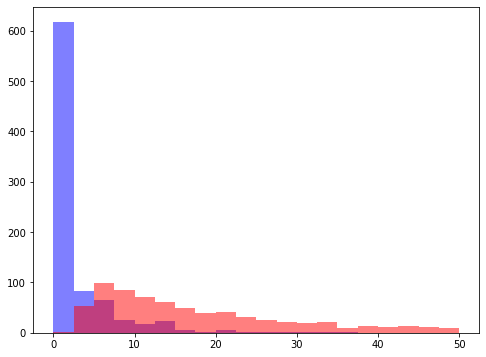

In [60]:
fig = plt.figure(figsize=(8,6))
plt.hist(constraints[:,5],bins=20,range=(0,50),color='b',alpha=0.5)
plt.hist(constraints[:,6],bins=20,range=(0,50),color='r',alpha=0.5)
plt.show()

In [105]:
print(KOIs['koi_ror','koi_ror_err1','koi_ror_err2','koi_prad','koi_pmass','koi_pmass_err1','koi_pmass_err2'][KOIs['kepid']==3634051])
print(KOIs['koi_ror','koi_prad','koi_pmass','koi_pmass_err1','koi_pmass_err2'][KOIs['kepid']==5792202])


koi_ror  koi_ror_err1 koi_ror_err2 ...   koi_pmass_err1     koi_pmass_err2 
-------- ------------ ------------ ... ------------------ -----------------
 0.02813     0.002815    -0.001308 ...  40.82081940581523 15.77384467707266
0.361369     6.952184    -0.064837 ... 11.688491984658098 5.465785169648067
koi_ror  koi_prad     koi_pmass        koi_pmass_err1     koi_pmass_err2  
-------- -------- ------------------ ------------------ ------------------
0.024555     2.19  7.079457843841379  5.509796274100296 3.0983861383064064
0.269007     24.0 10.964781961431852  8.533664036148602  4.939186100688274
0.041532     3.71               10.0 7.7827941003892285  4.376586748096509
   0.056      5.0 22.908676527677734 17.829351252733545 10.026181010746392
0.072904      6.5  42.65795188015925 44.438407115448804 19.215663726960027


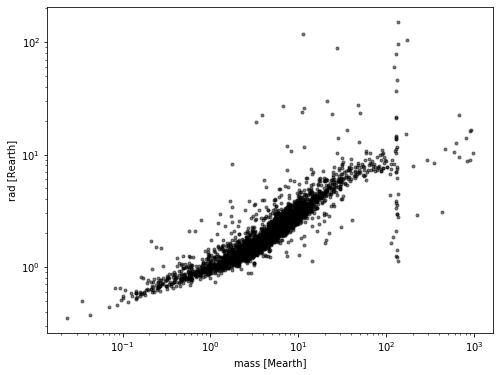

In [84]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(KOIs['koi_pmass'],KOIs['koi_prad'],'k.',alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mass [Mearth]')
ax.set_ylabel('rad [Rearth]')
plt.show()

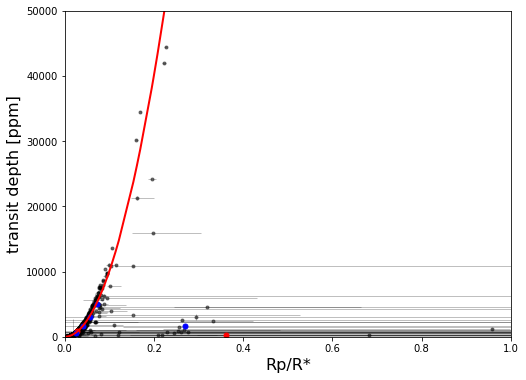

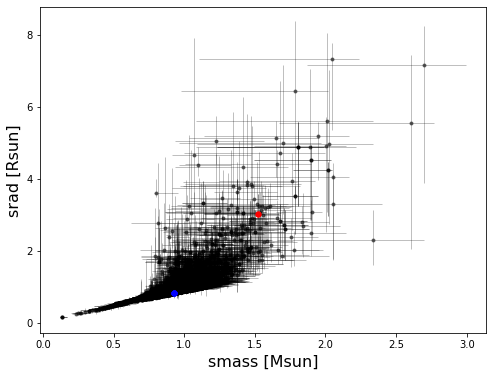

In [128]:
ror_err = np.vstack((np.abs(np.array(KOIs['koi_ror_err2'])).T,np.abs(np.array(KOIs['koi_ror_err1'])).T))
depth_err = np.vstack((np.abs(np.array(KOIs['koi_depth_err2'])).T,np.abs(np.array(KOIs['koi_depth_err1'])).T))

srad_err = np.vstack((np.abs(np.array(KOIs['koi_srad_err2'])).T,np.abs(np.array(KOIs['koi_srad_err1'])).T))
smass_err = np.vstack((np.abs(np.array(KOIs['koi_smass_err2'])).T,np.abs(np.array(KOIs['koi_smass_err1'])).T))


fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(KOIs['koi_ror'],KOIs['koi_depth'],xerr=ror_err,yerr=depth_err,color='k',marker='.',ls='None',elinewidth=0.5,alpha=0.5,zorder=1)
ax.plot(KOIs['koi_ror'][KOIs['kepid']==3634051],KOIs['koi_depth'][KOIs['kepid']==3634051],color='r',marker='.',ms=10,ls='None')
ax.plot(KOIs['koi_ror'][KOIs['kepid']==5792202],KOIs['koi_depth'][KOIs['kepid']==5792202],color='b',marker='.',ms=10,ls='None')

ax.plot(np.sort(KOIs['koi_ror']),1000000*(np.sort(KOIs['koi_ror']))**2,'r-',lw=2,zorder=2)

ax.set_ylabel('transit depth [ppm]',fontsize=16)
ax.set_xlabel('Rp/R*',fontsize=16)
ax.set_ylim(0,50000)
ax.set_xlim(0,1)
plt.show()

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(KOIs['koi_smass'],KOIs['koi_srad'],xerr=smass_err,yerr=srad_err,color='k',marker='.',ls='None',elinewidth=0.5,alpha=0.5,zorder=1)
ax.plot(KOIs['koi_smass'][KOIs['kepid']==3634051],KOIs['koi_srad'][KOIs['kepid']==3634051],color='r',marker='.',ms=10,ls='None')
ax.plot(KOIs['koi_smass'][KOIs['kepid']==5792202],KOIs['koi_srad'][KOIs['kepid']==5792202],color='b',marker='.',ms=10,ls='None')

ax.set_ylabel('srad [Rsun]',fontsize=16)
ax.set_xlabel('smass [Msun]',fontsize=16)

plt.show()